In this notebook, we will run a ready-made network starting from some ATLAS data, which is already normalized. There is also an alternative to train the network from scratch.  

## Look into the dataset

First we need to make sure that Python 3.8 is used in the notebook. It is required in order to open this certain .pkl-file. 

In [1]:
#importing various libraries
import numpy as np
import pandas as pd

In [ ]:
#we need to find the maximum number of particle in one single event
#this is done because we have different number of columns for each row, and we need to specify number of columns while 
# using pd.read_csv()
import sys
no_of_column = -1
#no_of_column is initially negative as no dataset will have a negative number of columns 
index11 = 1
# index11 is used to keep a track of how many iteration have been done
while (no_of_column == -1):
  
  try :
    my_cols = [str(i) for i in range(index11)]
    reading_data = pd.read_csv("/content/monojet_Zp2000.0_DM_50.0_chan3.csv",sep =',|;',names = my_cols, header=None)
    no_of_column  =  index11
  except :
    index11 = index11 + 1

print(no_of_column)

In [43]:
#two different delimiter are used (, and ;)
#as the number of columns are not same in every row, therefore we need to specify number of columns while using pd.read_csv()
#Note : the exact number of columns required was obtained by iteration method and hit and trail method 

my_cols = [str(i) for i in range(no_of_column)]
train_data1 = pd.read_csv("/content/monojet_Zp2000.0_DM_50.0_chan3.csv",sep =',|;',names = my_cols, header=None, engine = 'python')


In [44]:
#initial columns of dataset, ["event ID","process ID","event weight","MET","METphi"] contain information about the event, and hence not useful 
#as the next 'type' object is separated from the previous particle 'phi' detail with a ';' delimiter, all last columns will have 
#'NaN' value instead of 'type' detail, therefore all these columns are dropped.
train_data1.drop(['0','1','2','3','4'],axis = 1 ,inplace = True)
train_data1.drop([str(len(my_cols) -1 )],axis = 1 ,inplace = True)

In [45]:
# as each particle will have 5 reading,['type','E','pt','eta','phi'] 
max_reading = int(len(train_data1.columns)/5)
# max_reading tells maximum number of particle information which a row compared to all the rows will have.

In [ ]:
#check about how data looks right now
train_data1.head()

In [ ]:
# 1st particle of each row, first 5 columns are sliced into a new dataframe data1, columns names are given, and all the na values rows
# are droppped, incase if in a event no particle information is recorded. 
data1 = train_data1[train_data1.columns[0:5]]
data1.columns = ['Type', 'm', 'pt', 'eta', 'phi']
data1.dropna(inplace = True)
print(data1)
#data1 right now is of shape (6399,5)

In [49]:
# the same slicing is done for all the columns, stored into a local dataframe 'data', the na values are removed and dataframe is stored in 
# 'remove' and then data and data1 dataframes are concated
# Note: 'm' name column represent data of 'E'
for index in range(1, max_reading):
  data = train_data1[train_data1.columns[ 5 * index : 5*(index + 1)]]
  data.columns = ['Type', 'm', 'pt', 'eta', 'phi']
  remove = data.dropna()
  data1 = pd.concat([data1, remove], axis=0)

In [ ]:
data1.shape
# data1, concated with all particle information in 5 columns now has total of 23473 rows and 5 columns with no na values

In [51]:
# all rows with particle of type 'j' is selected and stored in data_select
data_select = data1.loc[data1['Type'] == 'j']
data_select = data_select[['pt', 'eta', 'phi', 'm']]
# the columns are rearranged in ['pt','eta','phi','m'] format

In [ ]:
# the dataset is broken randomly into 80:20 ratio with help of train_test_split
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_select, test_size=0.2,random_state = 45)

print(train.shape)
print(test.shape)
train.describe()

In [ ]:
#feature scaling is done, as the data is very screwed
#feature scaling is done after dividing the dataset into train and test, to avoid any bias that one set can do on other one .
#Standard Scaler is used for feature MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
train[['pt', 'eta', 'phi','m']] = MinMaxScaler().fit_transform(train[['pt', 'eta', 'phi','m']])
test[['pt', 'eta', 'phi','m']] = MinMaxScaler().fit_transform(test[['pt', 'eta', 'phi','m']])


train.describe()

In [ ]:
print(train)
print(test)

In [ ]:
# plot to know what type of data we have after feature scaling
import matplotlib.pyplot as plt

unit_list = ['[log(GeV)]', '[rad/3]', '[rad/3]', '[log(GeV)]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$m$']

branches=['pt', 'eta', 'phi', 'm']

n_bins = 100

for kk in range(0,4):
    n_hist_data, bin_edges, _ = plt.hist(train[branches[kk]], color='blue', label='Input', alpha=1, bins=n_bins)
    plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('# of events')
    plt.savefig("fourmomentum_"+branches[kk],dpi=300)
    plt.show()

In [ ]:
# there was a problem running this file on local python environment, this notebook was runned on colab

!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

We take a pickle dataset, and open into Pandas (after importing pandas). Note that you have to change the paths to the directory where your processed files are. 

Now we plot the data using the matplotlib library. The units reflect the normalization, but it's the shape that we care about. 

### Preparing the data

Adding the two datasets as TensorDatasets to PyTorch (also loading all other classes we'll need later)

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core

train_x = train
test_x = test
train_y = train_x  # y = x since we are building an autoencoder
test_y = test_x

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

We now set things up to load the data, and we use a batch size that was optimized by previous students...note also that this is fastai v2, migration thanks to Jessica Lastow.

In [22]:
bs = 256

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

### Preparing the network

Here we have an example network. Details aren't too important, as long as they match what was already trained for us...in this case we have a LeakyReLU, tanh activation function, and a number of layers that goes from 4 to 200 to 20 to 3 (number of features in the hidden layer that we pick for testing compression) and then back all the way to 4. 

In [ ]:
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

#model = AE_3D_200_LeakyReLU().double()
model = AE_3D_200_LeakyReLU()
model.to('cpu')

We now have to pick a loss function - MSE loss is appropriate for a compression autoencoder since it reflects the [(input-output)/input] physical quantity that we want to minimize. 

In [24]:
from fastai.metrics import mse

loss_func = nn.MSELoss()

#bn_wd = False  # Don't use weight decay for batchnorm layers
#true_wd = True  # weight decay will be used for all optimizers
wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)
#was: learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

## Alternative 1: Running a pre-trained network

Now we load the pre-trained network. 

## Alternative 2: Training a new network

Instead of using a pre-trained network, an alternative is to train a new network and use that instead. 

First, we want to find the best learning rate. The learning rate is a hyper-paramater that sets how much the weights of the network will change each step with respect to the loss gradient.

Then we plot the loss versus the learning rates. We're interested in finding a good order of magnitude of learning rate, so we plot with a log scale.

A good value for the learning rates is then either:
- one tenth of the minimum before the divergence
- when the slope is the steepest

Learning rate with the minimum loss: 0.0019054606556892395
Learning rate with the steepest gradient: 0.0003311311302240938


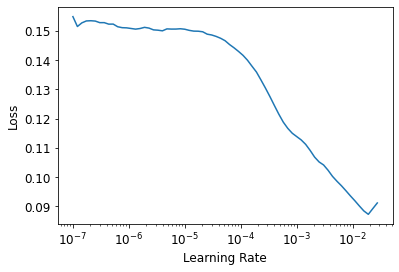

In [25]:
from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

Now we want to run the training!

User-chosen variables:
- n_epoch: The number of epochs, i.e how many times the to run through all of the training data once (i.e the 1266046 entries, see cell 2)
- lr: The learning rate. Either choose lr_min, lr_steep from above or set your own.


In [ ]:
import time

start = time.perf_counter() # Starts timer
learn.fit_one_cycle(n_epoch=100, lr_max=lr_min)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

Then we plot the loss as a function of batches and epochs to check if we reach a plateau.

In [ ]:
recorder.plot_loss()

Then we evaluate the MSE on this network - it should be of the order of 0.001 or less if all has gone well...if it has not trained as well (note the pesky 0-mass peak above...) then it's going to be a bit higher.

In [29]:
learn.validate()

(#1) [6.476144335465506e-05]

Let's plot all of this, with ratios (thanks to code by Erik Wallin)

## Plotting the outputs of the network

Lazy-save of our output files (they'll also be on screen)

In [30]:
import os
save_dir = "plotOutput"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

A function in case we want to un-normalize and get back to physical quantities...

In [31]:
def custom_unnormalize(df):
    df['eta'] = df['eta'] * 5
    df['phi'] = df['phi'] * 3
    #df['E'] = 10**df['E']
    df['m'] = 10**df['m']
    df['pt'] = 10**(df['pt'])
    return df

Make the histograms from the dataset...

In [ ]:
import numpy as np

plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

save = True # Option to save figure

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float)
#data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float).double()
pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=test.columns)
pred_df = pd.DataFrame(pred, columns=test.columns)

unnormalized_data_df = custom_unnormalize(data_df)
unnormalized_pred_df = custom_unnormalize(pred_df)    
    
alph = 0.8
n_bins = 200
for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(test.columns[kk])
    plt.xlabel(test.columns[kk])
    plt.ylabel('Number of events')
    # ms.sciy()
    plt.yscale('log')
    if save:
        plt.savefig(os.path.join(save_dir,test.columns[kk]+'.png'))
    plt.legend()

In [35]:
def getRatio(bin1,bin2):
    bins = []
    for b1,b2 in zip(bin1,bin2):
        if b1==0 and b2==0:
            bins.append(0.)
        elif b2==0:
            bins.append(None)
        else:
            bins.append((float(b2)-float(b1))/b1)
    return bins   

rat = getRatio(n_hist_data,n_hist_pred)
print(rat)

[0.06771463119709795, 0.03166666666666667, -0.017977528089887642, -0.008547008547008548, -0.008368200836820083, 0.019138755980861243, 0.012658227848101266, -0.06875, 0.21875, -0.2108843537414966, 0.3870967741935484, -0.15789473684210525, 0.13043478260869565, -0.12359550561797752, 0.06493506493506493, -0.06172839506172839, 0.01818181818181818, 0.01639344262295082, -0.08771929824561403, -0.24, 0.022727272727272728, -0.14634146341463414, -0.24324324324324326, -0.03125, -0.41379310344827586, 0.0, 0.23529411764705882, -0.05263157894736842, -0.047619047619047616, -0.42105263157894735, 0.36363636363636365, -0.42105263157894735, 0.3076923076923077, 0.7142857142857143, -0.5, 0.0, -0.6, -0.5555555555555556, 1.0, -0.16666666666666666, -0.5, 0.25, -0.3333333333333333, -0.2, -0.6, 2.0, -0.25, 1.3333333333333333, 0.25, 1.0, -0.4, None, -0.8333333333333334, -0.6666666666666666, 1.0, None, 3.0, 0.0, 0.0, 1.0, 0.3333333333333333, 1.0, -0.75, inf, 0.0, 0.0, None, None, 0.0, inf, 1.0, None, inf, -0.5, in

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
